# VQE (Variational Quantum Eigensolver)でH<sub>2</sub>の基底エネルギーの計算をする

Qiskit (https://qiskit.org/textbook/ja/ch-applications/vqe-molecules.html)

Quantum native dojo (https://dojo.qulacs.org/ja/latest/notebooks/5.1_variational_quantum_eigensolver.html#VQE%E3%81%A8%E3%81%AF)

を参考にした

In [1]:
!pip install pyscf
!pip install qiskit

     |████████████████████████████████| 29.7 MB 81 kB/s 
     |████████████████████████████████| 6.1 MB 6.6 MB/s 
     |████████████████████████████████| 18.0 MB 1.3 MB/s 
     |████████████████████████████████| 235 kB 61.7 MB/s 
     |████████████████████████████████| 207 kB 22.4 MB/s 
     |████████████████████████████████| 2.1 MB 51.5 MB/s 
     |████████████████████████████████| 200 kB 47.3 MB/s 
     |████████████████████████████████| 1.4 MB 35.7 MB/s 
     |████████████████████████████████| 635 kB 20.0 MB/s 
     |████████████████████████████████| 68 kB 5.3 MB/s 
     |████████████████████████████████| 33.9 MB 19 kB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 943 kB 36.7 MB/s 
     |████████████████████████████████| 3.2 MB 40.0 MB/s 
     |████████████████████████████████| 6.3 MB 41.5 MB/s 
  Created wheel for qiskit: filename=qiskit-0.29.0-py3-none-any.whl size=11179 sha256=fdabc1f57a8f5a76de833469c345007f6cb939d1301e2f826c3

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


PySCFを用いてモデルを作成する関数を定義

In [3]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="H .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

qasm_simulatorを用いて量子計算を行う。

パラメータの最適化はSimultaneous Perturbation Stochastic Approximation (SPSA)、Sequential Least Squares Programming (SLSQP)、Constrained Optimization by Linear Approximation (COBYLA)のいずれかで行う。（それぞれがどのような手法なのかは理解していない。）

Qiskitからの説明によると、ノイズのある目的関数を最適化するときはSPSAを用いるとよく、コスト関数の評価にノイズの無い場合は古典optimizerであるSLSQPやCOBYLAを用いるとよいらしい。

In [61]:
backend = BasicAer.get_backend("qasm_simulator")
distances = np.arange(0.2, 3.0, 0.1)
exact_energies = []
vqe_energies = []
energy_differences = []
optimizer = COBYLA(maxiter=100) # maxiterの値を変えると最適化の繰り返し数を変更できる

for dist in distances:
  qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
  result = NumPyEigensolver(qubitOp).run()
  exact_energies.append(np.real(result.eigenvalues) + shift)
  initial_state = HartreeFock(
      num_spin_orbitals,
      num_particles,
      qubit_mapping='parity'
  ) 
  var_form = UCCSD(                   # EfficientSU2を用いる場合は
      num_orbitals=num_spin_orbitals, # var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear")
      num_particles=num_particles,    # とした。
      initial_state=initial_state,
      qubit_mapping='parity'
  )
  
  vqe = VQE(qubitOp, var_form, optimizer)
  vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
  vqe_energies.append(vqe_result)
  energy_differences.append(vqe_result - exact_energies[-1])
  print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/components/initial_states/hartree_fock.py:61: DeprecationWarning: The HartreeFock class is deprecated as of Aqua 0.9 and will be removed no earlier than 3 months after the release date. Instead, all algorithms and circuits accept a plain QuantumCircuit. 
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/components/variational_forms/uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]


Interatomic Distance: 0.2 VQE Result: 0.15262348645184964 Exact Energy: [0.15748213]
Interatomic Distance: 0.3 VQE Result: -0.6070199026891736 Exact Energy: [-0.60180371]
Interatomic Distance: 0.4 VQE Result: -0.8940504948231343 Exact Energy: [-0.9141497]
Interatomic Distance: 0.5 VQE Result: -1.0505858012115414 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.104364911442251 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.1320260757046272 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.1144345269886338 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.1251457438970154 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.086397718814011 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -1.0776115751463768 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -1.059271019562696 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -1.0044869034872663 E

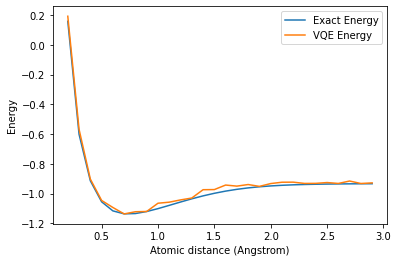

In [60]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
#plt.plot(distances, energy_differences)
plt.xlabel('Atomic distance (Angstrom)')
#plt.ylabel('Energy Difference')
plt.ylabel('Energy')
plt.legend()
plt.show()